In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from tensorflow.keras.callbacks import EarlyStopping


In [2]:
(x_train, _), (x_test, _) = tf.keras.datasets.fashion_mnist.load_data()

x_train = x_train.astype("float32") / 255.
x_test = x_test.astype("float32") / 255.

x_train = np.expand_dims(x_train, axis=-1)  # (28, 28, 1)
x_test = np.expand_dims(x_test, axis=-1)

# Add Gaussian noise for denoising
noise_factor = 0.4
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
def build_autoencoder():
    input_img = layers.Input(shape=(28, 28, 1))

    # Encoder
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    encoded = layers.MaxPooling2D((2, 2), padding='same')(x)  # bottleneck

    # Decoder
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    return models.Model(input_img, decoded), models.Model(input_img, encoded)

autoencoder, encoder = build_autoencoder()
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')


In [4]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = autoencoder.fit(
    x_train_noisy, x_train,
    epochs=50,
    batch_size=128,
    shuffle=True,
    validation_data=(x_test_noisy, x_test),
    callbacks=[early_stop]
)


Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 0.3600 - val_loss: 0.2976
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.2932 - val_loss: 0.2923
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.2888 - val_loss: 0.2897
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.2859 - val_loss: 0.2868
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.2839 - val_loss: 0.2852
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.2829 - val_loss: 0.2845
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.2823 - val_loss: 0.2835
Epoch 8/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.2807 - val_loss: 0.2831
Epoch 9/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.2811 - val_loss: 0.2826
Epoch 10/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.2803 - val_loss: 0.2820
Epoch 11/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.2788 - val_loss: 0.2818
Epoch 12/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/s

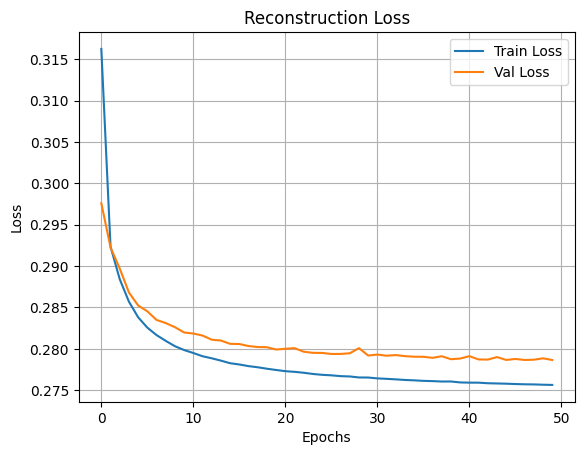

In [5]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Reconstruction Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


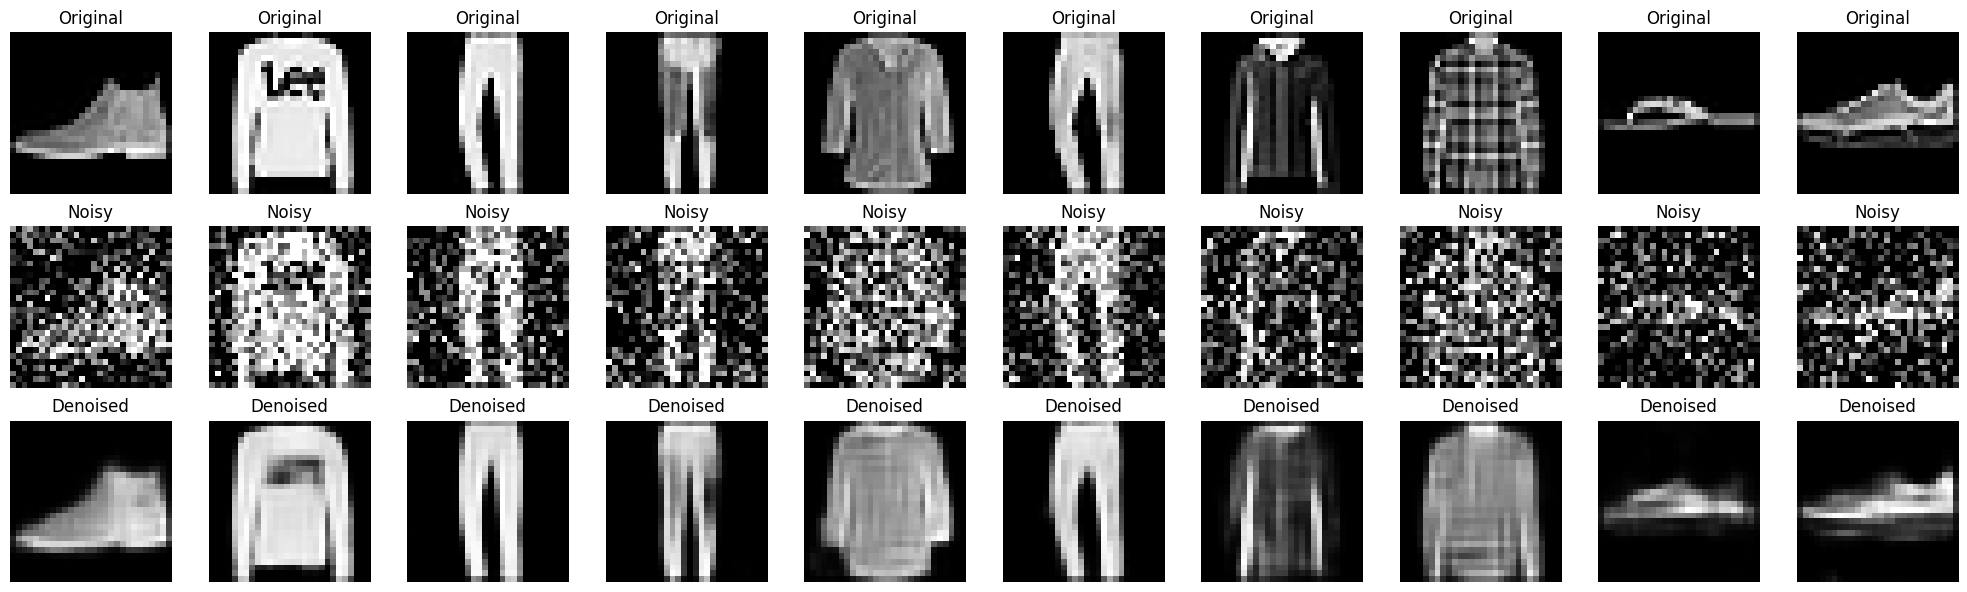

In [6]:
decoded_imgs = autoencoder.predict(x_test_noisy)

n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # Original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap="gray")
    plt.title("Original")
    plt.axis("off")

    # Noisy Input
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].reshape(28, 28), cmap="gray")
    plt.title("Noisy")
    plt.axis("off")

    # Reconstructed
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap="gray")
    plt.title("Denoised")
    plt.axis("off")
plt.tight_layout()
plt.show()


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


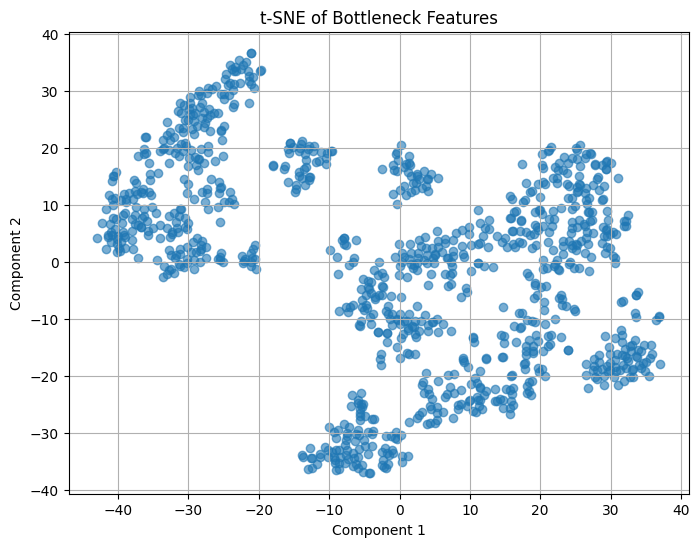

In [7]:
encoded_imgs = encoder.predict(x_test[:1000].astype('float32'))

# Flatten for t-SNE (from 7x7x64)
encoded_imgs_flat = encoded_imgs.reshape((1000, -1))

tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(encoded_imgs_flat)

plt.figure(figsize=(8, 6))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=0.6)
plt.title("t-SNE of Bottleneck Features")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)
plt.show()


## Objective
Objective
This project implements and compares two autoencoder architectures — a basic convolutional autoencoder and a denoising autoencoder — trained on the Fashion MNIST dataset. The goal is to learn compact latent representations, reconstruct inputs, visualize encoded features, and evaluate performance through reconstruction loss and visual quality.


## Model Architectures
1. Convolutional Autoencoder
Encoder:

Conv2D → ReLU → MaxPooling

Encodes the input into a lower-dimensional latent space (bottleneck).

Decoder:

Conv2DTranspose → ReLU → Output

Reconstructs the original image from the bottleneck.

2. Denoising Autoencoder
Adds Gaussian noise to the input images.

Trained to remove noise and recover clean images.

## Visualization
Original vs Reconstructed Outputs
Normal AE: Can reconstruct input images with moderate to good quality.

Denoising AE: Learns to clean up noise and reconstruct more clearly.

Bottleneck Visualization (t-SNE)
2D visualization of compressed features reveals clusters for different classes.

Denoising AE shows tighter, better-separated clusters due to convolutional layers.


## raining and Evaluation
Training Settings
Optimizer: Adam

Loss: Binary Crossentropy

EarlyStopping: Enabled

Epochs: 50 (with patience)
Loss Curves
Training and validation loss plotted over epochs.

Early stopping ensures no overfitting.

Denoising AE achieves lower reconstruction loss compared to basic AE.

## Conclusion
Autoencoders — especially denoising versions with convolutional layers — can learn powerful low-dimensional representations. They effectively reconstruct and clean images, with meaningful bottleneck features that can be visualized using dimensionality reduction techniques like t-SNE.